## 图像处理第四次作业
#### 请同学们完成后打包整个文件夹提交到教学网，压缩包名字为“姓名_学号_HW4”

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
# 预先安装 sklearn 库
from sklearn.cluster import KMeans

### Task 1 霍夫变换

图像"insurance_form.jpg"在传真过程遭受了轻微的旋转以及部分横线和竖线被抹去。

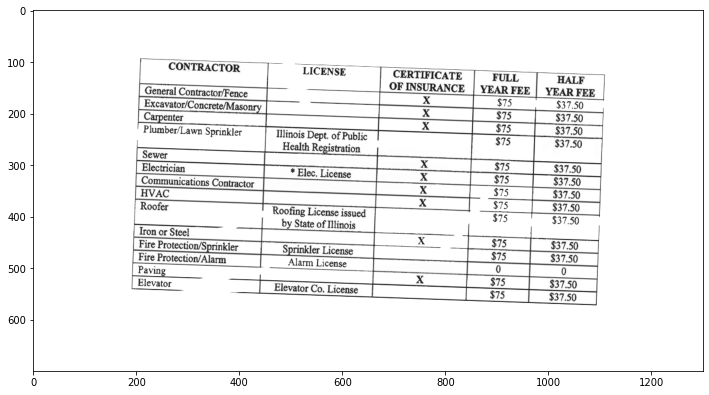

In [2]:
img = cv2.imread('insurance_form.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,12))
plt.imshow(img, cmap="gray")
plt.show()

#### 1.1 请设计算法将图像摆正并描述算法原理。

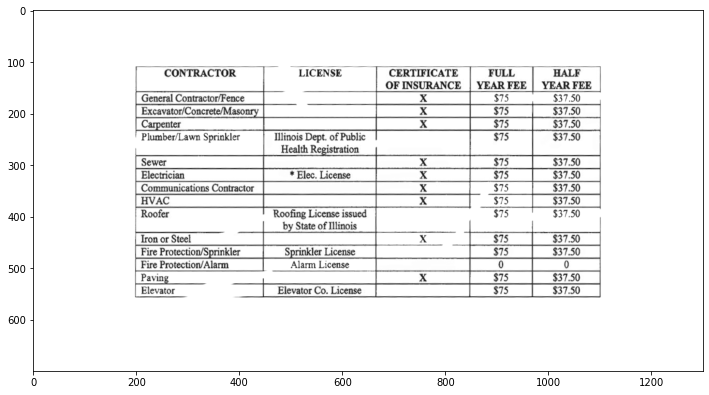

In [3]:
# 使用霍夫变换提取出图像的主要直线
edges = cv2.Canny(img, 50, 200)
lines = cv2.HoughLines(edges, 1, np.pi/180, 260)
lines = lines[:, 0, :]
thetas = []
for (rho, theta) in lines:
    if theta not in thetas:
        thetas.append(theta)

# print(thetas)
# plt.imshow(edges, cmap='gray')

h, w= img.shape
cx = int(w/2)
cy = int(h/2)

center = (cx, cy)
new_dim = (w, h)

# 直线的角度
angle = round(np.rad2deg(thetas[1]))

# 图像逆旋转angle角
M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
img = cv2.warpAffine(img, M, new_dim, borderValue=255)

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray')
plt.show()

##### 算法原理
使用canny算法提取出图像的边缘信息，用霍夫变换从边缘信息中提取出表格的水平边和竖直边，得到对应边与水平轴的夹角，将图像绕中心反向旋转对应角度即可。

#### 1.2 设计算法尽量补上缺失的直线部分。

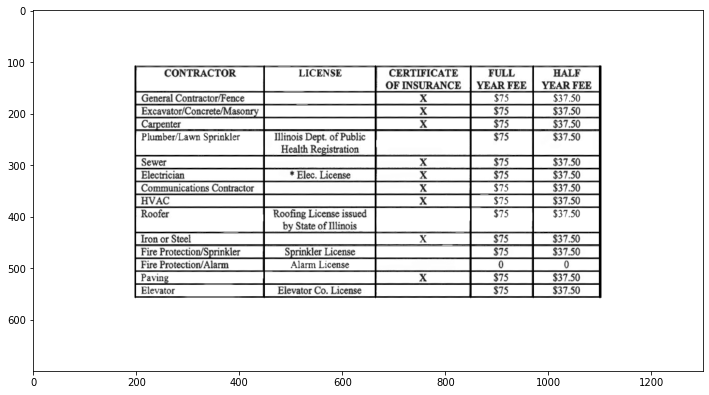

In [4]:
edges = cv2.Canny(img, 50, 200)
# 获取图像顶点坐标
row, col = edges.shape
left = right = top = bottom = 0
for i in range(row):
    if len(np.where(edges[i]==255)[0]) != 0:
        top = i
        break
for i in range(row-1, -1,-1):
    if len(np.where(edges[i]==255)[0]) != 0:
        bottom = i
        break
for i in range(col):
    if len(np.where(edges[:, i] == 255)[0]) !=0:
        left = i
        break
for i in range(col-1, -1, -1):
    if len(np.where(edges[:, i] == 255)[0]) !=0:
        right = i
        break

# 在霍夫变换找到的直线位置处将直线补全
lines = cv2.HoughLines(edges, 1, np.pi/180, 300)
lines = lines[:, 0, :]
thetas = []
for (rho, theta) in lines:
    if theta == 0:
        cv2.line(img, (round(rho), top), (round(rho), bottom), 0, 2)
    else:
        cv2.line(img, (left,round(rho)), (right, round(rho)), 0, 1)

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray')
plt.show()


### Task 2 形态学处理

图像"rice.tif"是在非均匀光照下得到的米粒图像，请实现书本（第四版）图9.42相应效果。

注：顶帽变换公式为 $T_{hat}(f) = f - (f \circ b)$，$f$为待处理灰度图，$b$为结构元，$\circ$为开运算。

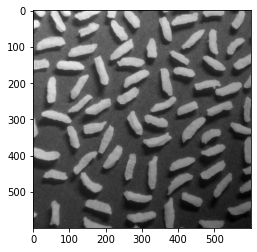

In [5]:
img = cv2.imread('rice.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")
plt.show()

#### 2.1 直接对原图使用Otsu阈值处理。

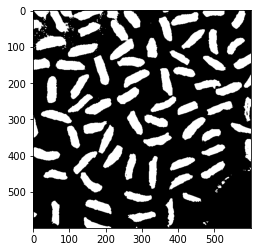

In [6]:
retval, ostu_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# print(ostu_img)
plt.imshow(ostu_img, cmap='gray')
plt.show()

#### 2.2 选择合适的结构元对原图进行开运算估计背景。

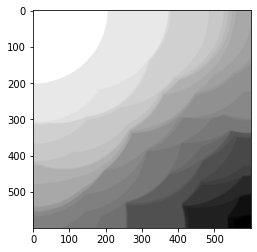

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (400, 400))
open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(open_img, cmap='gray')
plt.show()

#### 2.3 使用2.2的参数对原图使用顶帽变换。

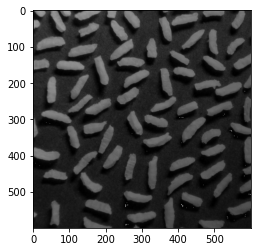

In [8]:
hat_img = img-open_img
plt.imshow(hat_img, cmap='gray')

#### 2.4 对顶帽变换后的结果使用Otsu阈值处理，对比2.1结果并进行简要分析。

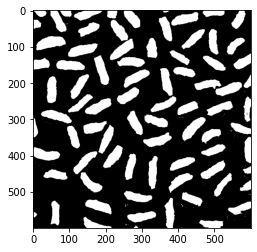

In [9]:
retval, ostu_hat_img = cv2.threshold(hat_img, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
plt.imshow(ostu_hat_img, cmap='gray')
plt.show()

### Task 3 k均值聚类分割

分割出图像"cherry.jpg"的白色背景并替换成其它颜色。

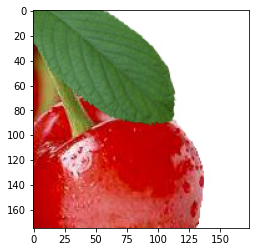

In [10]:
img = cv2.imread('cherry.jpg')
plt.imshow(img[:,:,::-1])  # 注意转换rgb通道顺序再展示图像
plt.show()

#### 3.1 仅使用rgb三颜色作为每个像素点的特征进行k均值聚类，类别数量k=3（仅使用颜色聚类会使樱桃中的白色反光部分被分到白色背景类）。

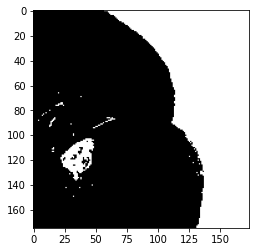

In [11]:
h, w, c = img.shape
reshape_img = img.reshape(h*w, 3)
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(reshape_img)
reshape_y_pred = y_pred.reshape(h, w)
mask_img_1 = np.where(reshape_y_pred==1, 255, 0)
plt.imshow(mask_img_1, cmap='gray')
plt.show()

#### 3.2 使用rgb和坐标信息作为每个像素点的特征进行k均值聚类（注意数值范围不同），类别数量k=3，调整颜色和坐标权重从而尽量分离出干净的白色背景部分。

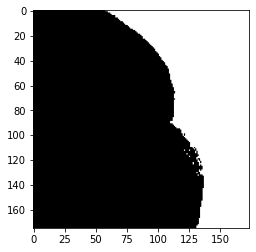

In [12]:
copy_img = img.copy().tolist()

# 位置的权重
weight = 2.9

for i in range(h):
    for j in range(w):
        copy_img[i][j]+=[weight*i,weight*j]
copy_img = np.array(copy_img)
reshape_copy_image = copy_img.reshape(h*w, c+2)

# K-Means算法
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(reshape_copy_image)
reshape_y_pred = y_pred.reshape(h, w)
mask_img_2 = np.where(reshape_y_pred==1, 255, 0)
plt.imshow(mask_img_2, cmap='gray')
plt.show()

#### 3.3 将3.2中分割出的白色背景替换为蓝色，展示结果。

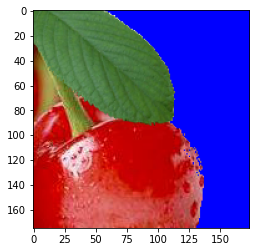

In [13]:
replace_img = img[:, :, ::-1].copy()
replace_img[np.where(reshape_y_pred==1)]=[0, 0, 255]
plt.imshow(replace_img)
plt.show()